In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [34]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 6

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')
all_district_var_ts_LI = pd.read_pickle('data/all_district_var_ts_LI.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts_LI[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)


# Normalize the data for training

In [35]:
# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [36]:
# convert all data 

lookback = 6
num_features = len(train_lstm_df_dict_scaled[1].columns)

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)


In [37]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
18


24

# LSTM Model on district 1

In [38]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/20


## Get predictions and plot

In [ ]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-05 11:50:58.087132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:50:58.569147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:50:58.688537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/21 [>.............................] - ETA: 49s

2023-04-05 11:50:58.794878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 3s 28ms/step
(21, 1)
(24, 9)


In [ ]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


21/21 [==============================] - 0s 18ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 228218.77 RMSE
Test Score: 434867.74 RMSE


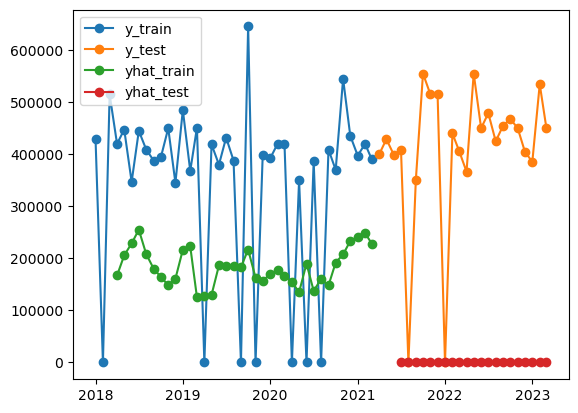

434867.7363236299

In [ ]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=lookback,
)


# LSTM on all districts

district_no 1
Epoch 1/20


2023-04-05 11:51:06.156296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:07.081784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:07.296436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:07.504236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:07.745429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:07.986748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:08.247015: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 90ms/step - loss: 0.1634
Epoch 2/20
36/36 [==============================] - 2s 65ms/step - loss: 0.1472
Epoch 3/20
36/36 [==============================] - 2s 67ms/step - loss: 0.1479
Epoch 4/20
36/36 [==============================] - 2s 68ms/step - loss: 0.1463
Epoch 5/20
36/36 [==============================] - 2s 64ms/step - loss: 0.1431
Epoch 6/20
36/36 [==============================] - 2s 66ms/step - loss: 0.1421
Epoch 7/20
36/36 [==============================] - 2s 67ms/step - loss: 0.1428
Epoch 8/20
36/36 [==============================] - 2s 67ms/step - loss: 0.1409
Epoch 9/20
36/36 [==============================] - 2s 64ms/step - loss: 0.1410
Epoch 10/20
36/36 [==============================] - 2s 66ms/step - loss: 0.1395
Epoch 11/20
36/36 [==============================] - 2s 66ms/step - loss: 0.1380
Epoch 12/20
36/36 [==============================] - 2s 66ms/step - loss: 0.1382
Epoch 13/20
36/36 [=============================

2023-04-05 11:51:58.194027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:58.662778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:51:58.821877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 2/36 [>.............................] - ETA: 1s  

2023-04-05 11:51:58.955686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 16ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 248082.48 RMSE
Test Score: 434867.74 RMSE


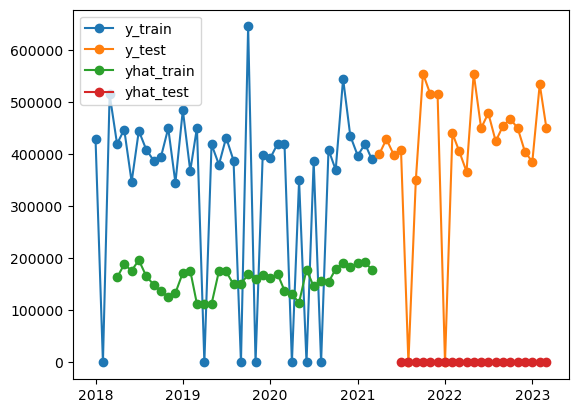

district_no 2
Epoch 1/20


2023-04-05 11:52:06.150621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:06.990320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:07.237776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:07.487299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:07.789983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:08.069878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:08.337273: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 66ms/step - loss: 0.2090
Epoch 2/20
36/36 [==============================] - 2s 46ms/step - loss: 0.1812
Epoch 3/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1798
Epoch 4/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1779
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1773
Epoch 6/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1770
Epoch 7/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1773
Epoch 8/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1758
Epoch 9/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1768
Epoch 10/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1756
Epoch 11/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1761
Epoch 12/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1761
Epoch 13/20
36/36 [=============================

2023-04-05 11:52:41.586708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:42.049115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:42.170327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/36 [=>............................] - ETA: 0s  

2023-04-05 11:52:42.287091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 499846.97 RMSE
Test Score: 935289.04 RMSE


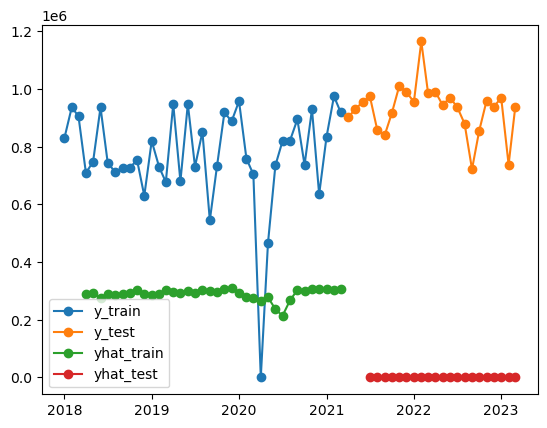

district_no 3
Epoch 1/20


2023-04-05 11:52:49.549317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:50.432644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:50.663844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:50.906919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:51.178888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:51.457835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:52:51.712420: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 51ms/step - loss: 0.1328
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1147
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1130
Epoch 4/20
36/36 [==============================] - 1s 37ms/step - loss: 0.1126
Epoch 5/20
36/36 [==============================] - 1s 37ms/step - loss: 0.1134
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1128
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1128
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1121
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1108
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1124
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1115
Epoch 12/20
36/36 [==============================] - 1s 37ms/step - loss: 0.1115
Epoch 13/20
36/36 [=============================

2023-04-05 11:53:21.397418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:21.869716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:21.989432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/36 [=>............................] - ETA: 1s  

2023-04-05 11:53:22.107123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 76446.19 RMSE
Test Score: 189885.20 RMSE


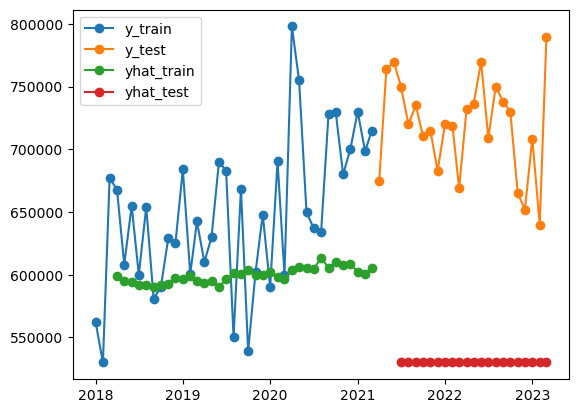

district_no 4
Epoch 1/20


2023-04-05 11:53:29.442328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:30.300629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:30.517255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:30.753522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:31.043207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:31.319319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:53:31.643817: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 8s 51ms/step - loss: 0.0917
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0848
Epoch 3/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0879
Epoch 4/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0851
Epoch 5/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0851
Epoch 6/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0846
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0849
Epoch 8/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0846
Epoch 9/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0845
Epoch 10/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0844
Epoch 11/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0840
Epoch 12/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0852
Epoch 13/20
36/36 [=============================

2023-04-05 11:54:00.662206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:01.132142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:01.274707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/36 [=>............................] - ETA: 0s  

2023-04-05 11:54:01.418491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 95779.18 RMSE
Test Score: 269154.34 RMSE


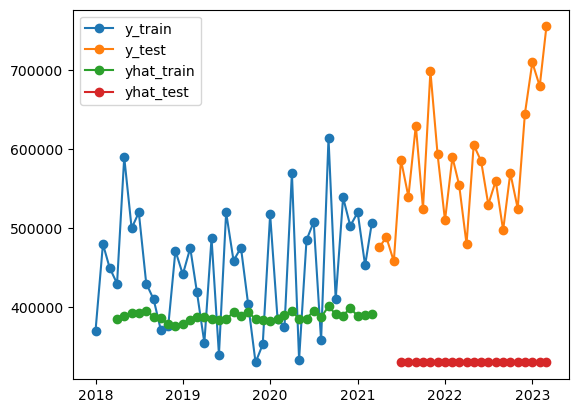

district_no 5
Epoch 1/20


2023-04-05 11:54:08.488321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:09.382462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:09.617010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:09.844396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:10.138131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:10.427206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:10.700907: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 53ms/step - loss: 0.1144
Epoch 2/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1067
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1063
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1053
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1042
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1050
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1045
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1043
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1039
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1051
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1052
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1032
Epoch 13/20
36/36 [=============================

2023-04-05 11:54:40.241349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:40.729365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:40.856761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:15

2023-04-05 11:54:40.998950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 89070.29 RMSE
Test Score: 245152.33 RMSE


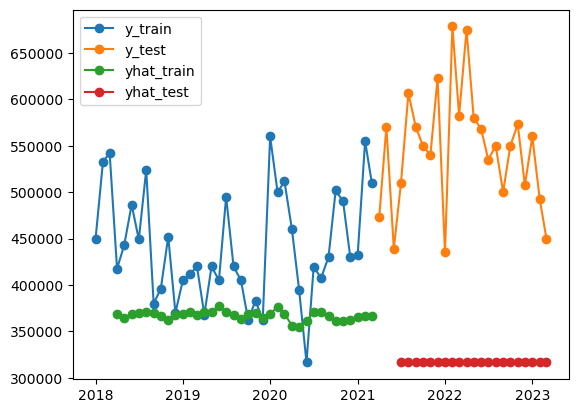

district_no 7
Epoch 1/20


2023-04-05 11:54:48.285080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:49.170620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:49.406362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:49.642424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:49.918225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:50.202517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:54:50.475545: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 80ms/step - loss: 0.2051
Epoch 2/20
36/36 [==============================] - 2s 47ms/step - loss: 0.1766
Epoch 3/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1795
Epoch 4/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1756
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1758
Epoch 6/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1758
Epoch 7/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1761
Epoch 8/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1752
Epoch 9/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1759
Epoch 10/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1743
Epoch 11/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1739
Epoch 12/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1736
Epoch 13/20
36/36 [=============================

2023-04-05 11:55:25.105298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:25.577283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:25.723128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:17

2023-04-05 11:55:25.877816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 213307.12 RMSE
Test Score: 471418.58 RMSE


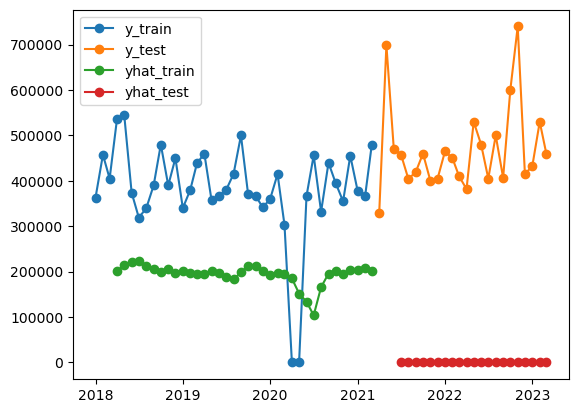

district_no 8
Epoch 1/20


2023-04-05 11:55:33.400431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:34.284908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:34.528965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:34.782129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:35.102252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:35.412499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:55:35.712557: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 10s 86ms/step - loss: 0.1700
Epoch 2/20
36/36 [==============================] - 2s 48ms/step - loss: 0.1445
Epoch 3/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1443
Epoch 4/20
36/36 [==============================] - 2s 41ms/step - loss: 0.1438
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1429
Epoch 6/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1434
Epoch 7/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1427
Epoch 8/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1437
Epoch 9/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1430
Epoch 10/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1415
Epoch 11/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1430
Epoch 12/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1424
Epoch 13/20
36/36 [============================

2023-04-05 11:56:11.352986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:11.930550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:12.087176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:58

2023-04-05 11:56:12.250424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 264973.94 RMSE
Test Score: 569304.84 RMSE


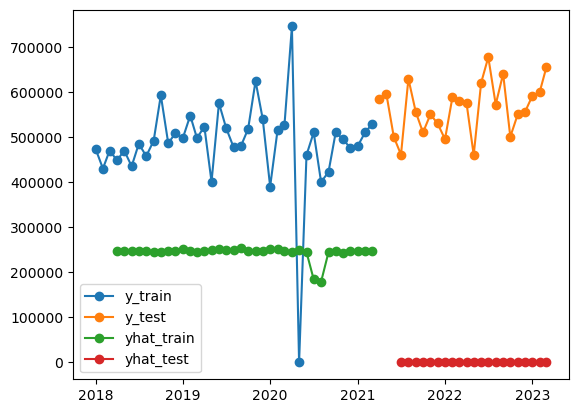

district_no 10
Epoch 1/20


2023-04-05 11:56:19.212319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:20.056107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:20.303918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:20.551884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:20.870020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:21.170459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:21.465291: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 63ms/step - loss: 0.0566
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0535
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0535
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0532
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0520
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0520
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0521
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0515
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0517
Epoch 12/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0518
Epoch 13/20
36/36 [=============================

2023-04-05 11:56:51.257908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:51.732860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:56:51.878928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:17

2023-04-05 11:56:52.043664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 79256.27 RMSE
Test Score: 263488.43 RMSE


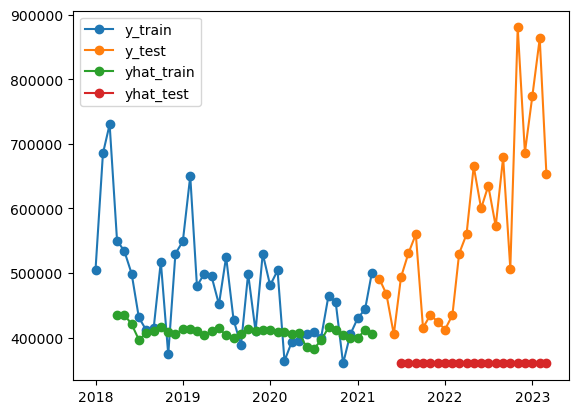

district_no 11
Epoch 1/20


2023-04-05 11:56:59.492899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:00.454018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:00.782069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:01.087257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:01.457241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:01.755435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:02.059056: I tensorflow/core/grappler/optimizers/cust

24/24 [==============================] - 12s 172ms/step - loss: 0.0929
Epoch 2/20
24/24 [==============================] - 3s 118ms/step - loss: 0.0868
Epoch 3/20
24/24 [==============================] - 3s 109ms/step - loss: 0.0846
Epoch 4/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0832
Epoch 5/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0831
Epoch 6/20
24/24 [==============================] - 3s 106ms/step - loss: 0.0816
Epoch 7/20
24/24 [==============================] - 3s 103ms/step - loss: 0.0849
Epoch 8/20
24/24 [==============================] - 3s 105ms/step - loss: 0.0811
Epoch 9/20
24/24 [==============================] - 3s 104ms/step - loss: 0.0822
Epoch 10/20
24/24 [==============================] - 3s 108ms/step - loss: 0.0802
Epoch 11/20
24/24 [==============================] - 3s 105ms/step - loss: 0.0809
Epoch 12/20
24/24 [==============================] - 3s 105ms/step - loss: 0.0797
Epoch 13/20
24/24 [================

2023-04-05 11:57:56.937858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:57.414988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:57:57.608919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/24 [>.............................] - ETA: 1:14

2023-04-05 11:57:57.798819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 25ms/step
yhat train shape (24, 9)
yhat test shape (21, 9)
y train shape (24,)
y test shape (21,)
Train Score: 211289.37 RMSE
Test Score: 232372.55 RMSE
model for district 11 cannot be evaluated
district_no 12
Epoch 1/20


2023-04-05 11:58:04.832962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:05.696129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:05.963762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:06.227583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:06.564791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:06.880815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:07.188436: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 59ms/step - loss: 0.1088
Epoch 2/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0930
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0945
Epoch 4/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0922
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0924
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0924
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0921
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0944
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0926
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0919
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0917
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0927
Epoch 13/20
36/36 [=============================

2023-04-05 11:58:37.262250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:37.768564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:37.931992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:21

2023-04-05 11:58:38.092424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 111334.97 RMSE
Test Score: 329419.28 RMSE


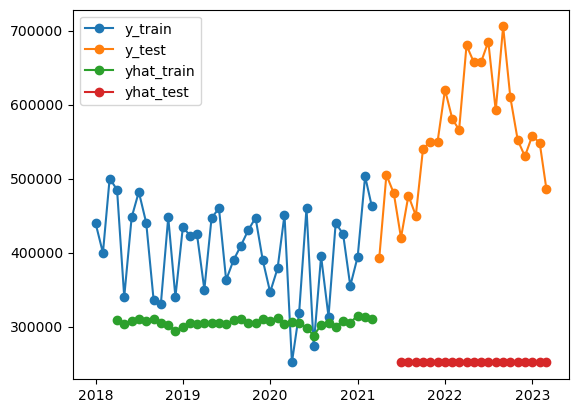

district_no 13
Epoch 1/20


2023-04-05 11:58:45.872249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:46.916140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:47.209885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:47.456395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:47.783765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:48.069599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:58:48.353352: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 9s 60ms/step - loss: 0.0768
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0677
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0674
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0665
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0656
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0681
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0667
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0666
Epoch 13/20
36/36 [=============================

2023-04-05 11:59:18.508633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:19.045209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:19.197768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:20

2023-04-05 11:59:19.384612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 100177.70 RMSE
Test Score: 222153.15 RMSE


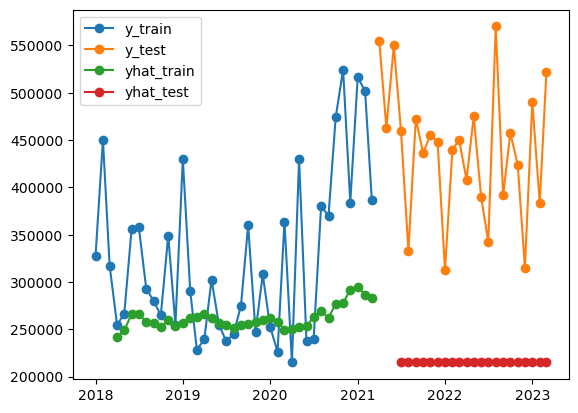

district_no 14
Epoch 1/20


2023-04-05 11:59:26.709854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:27.602327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:27.836902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:28.099710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:28.431047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:28.737420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:29.028092: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 10s 61ms/step - loss: 0.0736
Epoch 2/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0637
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0649
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0639
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0637
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0637
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0631
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 13/20
36/36 [============================

2023-04-05 11:59:59.094757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:59.574193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 11:59:59.711619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:17

2023-04-05 11:59:59.871422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 14ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 90939.63 RMSE
Test Score: 201110.57 RMSE


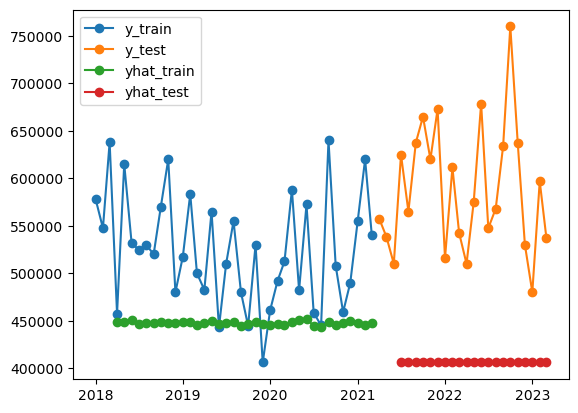

district_no 15
Epoch 1/20


2023-04-05 12:00:08.090216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:09.070455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:09.393443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:09.717636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:10.133292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:10.512999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:10.897517: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 10s 71ms/step - loss: 0.1415
Epoch 2/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1274
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1243
Epoch 4/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1233
Epoch 5/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1241
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1224
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1234
Epoch 8/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1227
Epoch 9/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1224
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1225
Epoch 11/20
36/36 [==============================] - 1s 38ms/step - loss: 0.1226
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1235
Epoch 13/20
36/36 [============================

2023-04-05 12:00:42.305514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:42.840228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:42.987636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/36 [..............................] - ETA: 1:27

2023-04-05 12:00:43.206869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 84886.60 RMSE
Test Score: 164552.03 RMSE


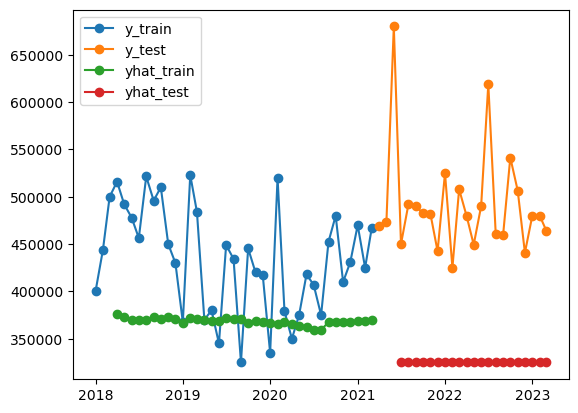

district_no 16
Epoch 1/20


2023-04-05 12:00:50.825252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:51.740321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:52.072284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:52.382535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:52.755513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:53.166750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:00:53.577799: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 10s 73ms/step - loss: 0.1064
Epoch 2/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0937
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0918
Epoch 4/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0926
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0920
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0915
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0907
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0926
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0914
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0906
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0904
Epoch 12/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0902
Epoch 13/20
36/36 [============================

2023-04-05 12:01:25.252554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:25.830657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:26.029058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:26.197990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 28555.17 RMSE
Test Score: 120678.39 RMSE


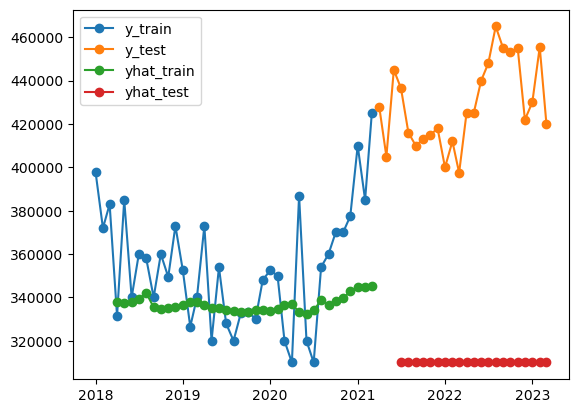

district_no 17
Epoch 1/20


2023-04-05 12:01:34.933608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:35.960480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:36.374078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:36.773385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:37.211673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:37.582874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:01:37.900095: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 14s 187ms/step - loss: 0.1137
Epoch 2/20
36/36 [==============================] - 4s 109ms/step - loss: 0.1064
Epoch 3/20
36/36 [==============================] - 4s 102ms/step - loss: 0.1052
Epoch 4/20
36/36 [==============================] - 4s 103ms/step - loss: 0.1024
Epoch 5/20
36/36 [==============================] - 4s 103ms/step - loss: 0.1031
Epoch 6/20
36/36 [==============================] - 4s 102ms/step - loss: 0.1009
Epoch 7/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0989
Epoch 8/20
36/36 [==============================] - 4s 107ms/step - loss: 0.0999
Epoch 9/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0970
Epoch 10/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0945
Epoch 11/20
36/36 [==============================] - 4s 101ms/step - loss: 0.0962
Epoch 12/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0929
Epoch 13/20
36/36 [================

2023-04-05 12:02:55.706477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:02:56.255984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:02:56.511344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:02:56.733817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 22ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 151712.88 RMSE
Test Score: 258702.53 RMSE


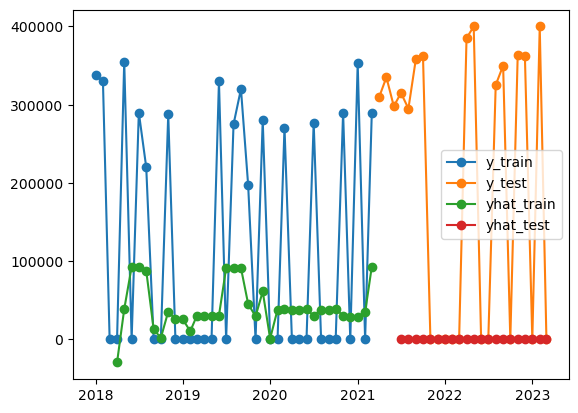

district_no 18
Epoch 1/20


2023-04-05 12:03:05.927522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:06.832581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:07.152201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:07.492678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:07.947415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:08.336013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:08.716046: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 88ms/step - loss: 0.0986
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0916
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0916
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0914
Epoch 5/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0914
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0915
Epoch 7/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0914
Epoch 8/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0921
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0915
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0912
Epoch 11/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0919
Epoch 12/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0919
Epoch 13/20
36/36 [============================

2023-04-05 12:03:40.516909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:41.099219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:41.326576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:41.554905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 28696.53 RMSE
Test Score: 130399.42 RMSE


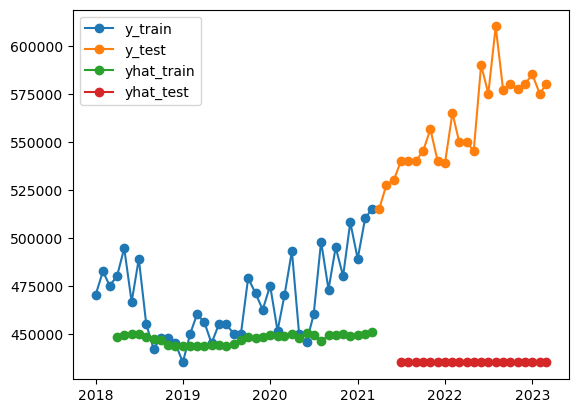

district_no 19
Epoch 1/20


2023-04-05 12:03:50.120460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:51.135502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:51.502767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:51.827929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:52.302969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:52.715087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:03:53.100884: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 86ms/step - loss: 0.0657
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0616
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0606
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0608
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0600
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0599
Epoch 8/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 10/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 12/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0599
Epoch 13/20
36/36 [============================

2023-04-05 12:04:25.709631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:26.270487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:26.522199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:26.740830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 13ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 21065.07 RMSE
Test Score: 122004.84 RMSE


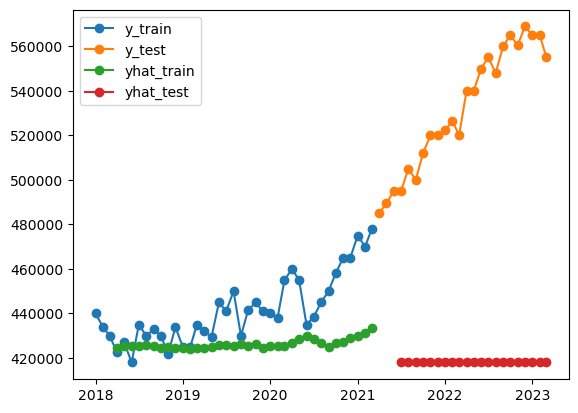

district_no 20
Epoch 1/20


2023-04-05 12:04:34.629609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:35.545609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:35.859775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:36.194296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:36.647137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:37.044522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:04:37.438210: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 88ms/step - loss: 0.1127
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0990
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0964
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0962
Epoch 5/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0969
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0956
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0955
Epoch 8/20
36/36 [==============================] - 2s 41ms/step - loss: 0.0956
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0953
Epoch 10/20
36/36 [==============================] - 1s 42ms/step - loss: 0.0956
Epoch 11/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0954
Epoch 12/20
36/36 [==============================] - 2s 42ms/step - loss: 0.0949
Epoch 13/20
36/36 [============================

2023-04-05 12:05:10.718300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:11.272638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:11.561747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:11.785243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 66255.49 RMSE
Test Score: 176975.07 RMSE


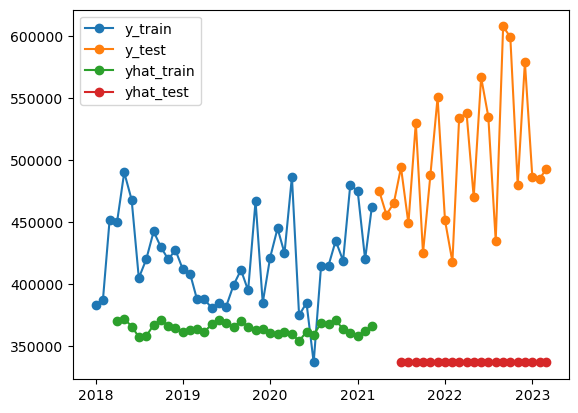

district_no 21
Epoch 1/20


2023-04-05 12:05:20.381190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:21.485070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:21.894171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:22.285363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:22.797372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:23.203160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:23.613178: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 91ms/step - loss: 0.1877
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1587
Epoch 3/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1595
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1585
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1591
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1605
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1573
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1581
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1575
Epoch 10/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1580
Epoch 11/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1578
Epoch 12/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1574
Epoch 13/20
36/36 [============================

2023-04-05 12:05:57.025247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:57.585881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:57.844127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:05:58.098711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 319943.21 RMSE
Test Score: 526750.27 RMSE


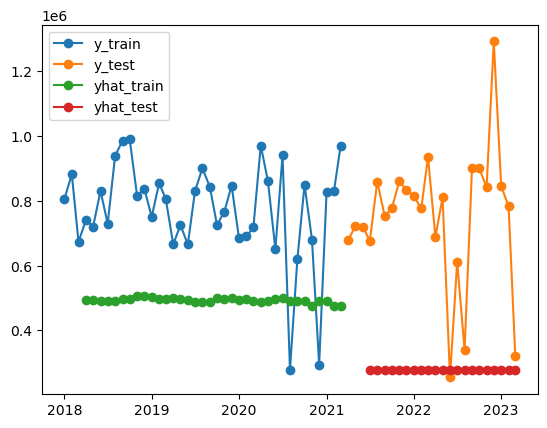

district_no 22
Epoch 1/20


2023-04-05 12:06:06.468920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:07.412623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:07.762886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:08.121413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:08.602617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:09.027746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:09.439169: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 12s 90ms/step - loss: 0.1134
Epoch 2/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0990
Epoch 3/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1019
Epoch 4/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1013
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0992
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0987
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0979
Epoch 8/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0974
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0985
Epoch 10/20
36/36 [==============================] - 2s 43ms/step - loss: 0.0971
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0990
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0979
Epoch 13/20
36/36 [============================

2023-04-05 12:06:42.549741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:43.157883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:43.392058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:43.708959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 14ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 25059.50 RMSE
Test Score: 120074.21 RMSE


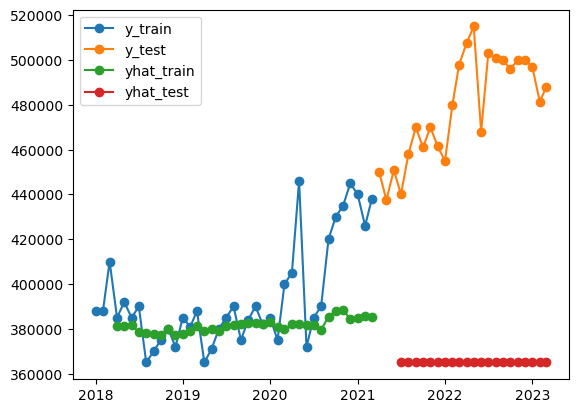

district_no 23
Epoch 1/20


2023-04-05 12:06:52.575812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:53.825394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:54.289763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:54.637614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:55.110711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:55.506443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:06:55.910408: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 92ms/step - loss: 0.1346
Epoch 2/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1167
Epoch 3/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1120
Epoch 4/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1123
Epoch 5/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1109
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1115
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1108
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1115
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1105
Epoch 10/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1105
Epoch 11/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1096
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1101
Epoch 13/20
36/36 [============================

2023-04-05 12:07:29.342432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:29.932138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:30.213372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:30.487660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 28991.43 RMSE
Test Score: 154286.30 RMSE


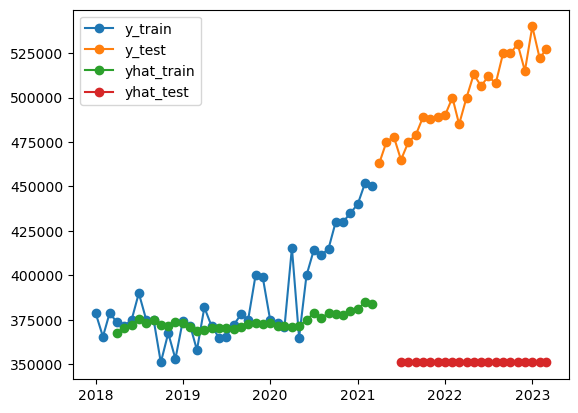

district_no 25
Epoch 1/20


2023-04-05 12:07:38.686319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:39.605074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:39.946551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:40.285253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:40.752822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:41.165273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:07:41.569230: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 88ms/step - loss: 0.0725
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0694
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0689
Epoch 4/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0696
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0692
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0690
Epoch 7/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0690
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0688
Epoch 9/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0687
Epoch 10/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0691
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0689
Epoch 12/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0691
Epoch 13/20
36/36 [============================

2023-04-05 12:08:14.255015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:14.762632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:14.985203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:15.223479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 14ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 31158.05 RMSE
Test Score: 159237.31 RMSE


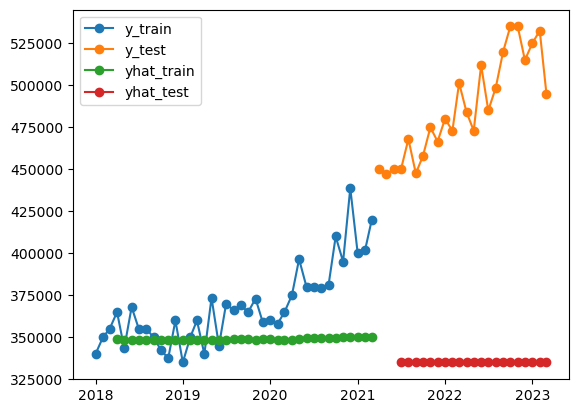

district_no 27
Epoch 1/20


2023-04-05 12:08:23.757129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:24.749187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:25.088093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:25.433005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:25.925506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:26.398914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:08:26.830190: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 93ms/step - loss: 0.1443
Epoch 2/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1275
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1275
Epoch 4/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1275
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1285
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1278
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1260
Epoch 8/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1269
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1268
Epoch 10/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1260
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1268
Epoch 12/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1263
Epoch 13/20
36/36 [============================

2023-04-05 12:08:59.740990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:00.247925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:00.466418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:00.699428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 14ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 30647.18 RMSE
Test Score: 142140.88 RMSE


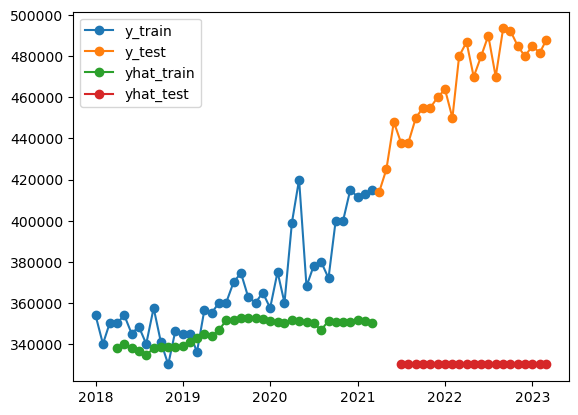

district_no 28
Epoch 1/20


2023-04-05 12:09:08.546072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:09.453872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:09.789880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:10.106637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:10.569163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:10.957381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:11.351199: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 88ms/step - loss: 0.1230
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1094
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1088
Epoch 4/20
36/36 [==============================] - 2s 41ms/step - loss: 0.1092
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1089
Epoch 6/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1092
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1086
Epoch 8/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1088
Epoch 9/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1093
Epoch 10/20
36/36 [==============================] - 1s 39ms/step - loss: 0.1087
Epoch 11/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1084
Epoch 12/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1083
Epoch 13/20
36/36 [============================

2023-04-05 12:09:43.747831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:44.330195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:44.582006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 12:09:44.807239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 14ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 22034.29 RMSE
Test Score: 125040.80 RMSE


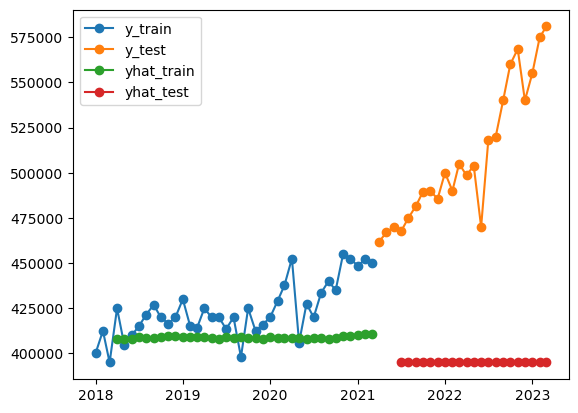

In [ ]:
# run the model for all districts
district_no_list = list(train_lstm_df_dict.keys())
test_score_dict = {}
for district_no in district_no_list:
    print("district_no", district_no)
    model = fit_lstm(train_lstm_dataset_dict[district_no])
    test_score = evaluate_lstm(
        model=model,
        X_train=train_lstm_dataset_dict[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict[district_no] = test_score       

In [ ]:
test_score_dict

{1: 434867.7363236299,
 2: 935289.0385721105,
 3: 189885.19985858124,
 4: 269154.3358878658,
 5: 245152.3335941689,
 7: 471418.5784479699,
 8: 569304.8368983084,
 10: 263488.428659274,
 11: None,
 12: 329419.28089521994,
 13: 222153.15394908038,
 14: 201110.56538275513,
 15: 164552.0344433349,
 16: 120678.38998563003,
 17: 258702.53035825124,
 18: 130399.42496956364,
 19: 122004.83873698655,
 20: 176975.06849217357,
 21: 526750.2680407029,
 22: 120074.20782324967,
 23: 154286.29849977576,
 25: 159237.31316736634,
 27: 142140.87984410799,
 28: 125040.8013927949}

# LSTM Model with linear interpolation

district_no 1 linear interpolation applied
Epoch 1/20


2023-04-05 21:13:39.238374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:40.556880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:41.149655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:41.760312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:42.558563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:43.423700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:13:43.951761: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 127ms/step - loss: 0.0797
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0814
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0766
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0754
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0762
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0752
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0749
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0736
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0737
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0741
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0750
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0759
Epoch 13/20
33/33 [===========================

2023-04-05 21:14:18.695233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:19.324554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:19.719262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:20.072416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 92ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 59144.68 RMSE
Test Score: 149832.67 RMSE


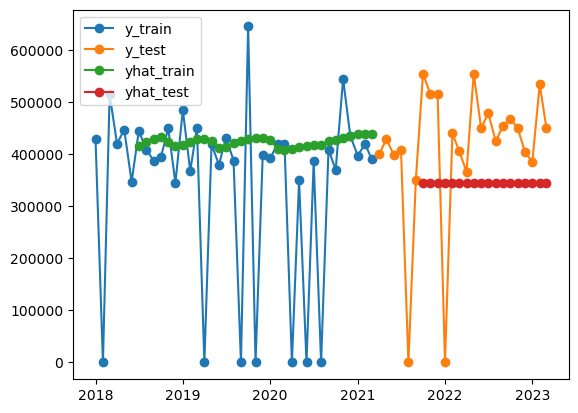

district_no 2 linear interpolation applied
Epoch 1/20


2023-04-05 21:14:31.978737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:33.126450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:33.856479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:34.422113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:35.257896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:35.887130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:14:36.486144: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 146ms/step - loss: 0.1507
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1278
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1262
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1245
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1259
Epoch 6/20
33/33 [==============================] - 2s 50ms/step - loss: 0.1237
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1258
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1244
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1232
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1218
Epoch 11/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1271
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1209
Epoch 13/20
33/33 [===========================

2023-04-05 21:15:12.060325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:13.133688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:13.522709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:13.963774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 147104.47 RMSE
Test Score: 481880.60 RMSE


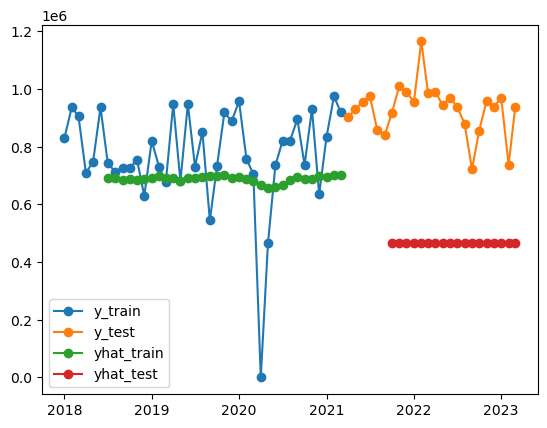

district_no 3 linear interpolation applied
Epoch 1/20


2023-04-05 21:15:23.610124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:24.907565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:25.505219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:25.965951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:26.764700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:27.439422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:15:28.039254: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 152ms/step - loss: 0.1282
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1019
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1010
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1034
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1017
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1014
Epoch 7/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0999
Epoch 8/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1007
Epoch 9/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1023
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1006
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1007
Epoch 12/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0996
Epoch 13/20
33/33 [===========================

2023-04-05 21:16:03.324100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:03.937037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:04.375472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:04.834285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 60009.89 RMSE
Test Score: 187180.72 RMSE


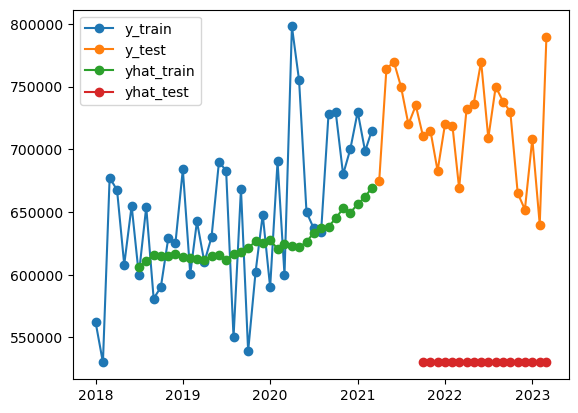

district_no 4 linear interpolation applied
Epoch 1/20


2023-04-05 21:16:15.138940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:16.229490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:16.843986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:17.414599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:18.100040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:18.731742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:19.330598: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 143ms/step - loss: 0.0973
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0820
Epoch 3/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0841
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0816
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0812
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0827
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0821
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0814
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0808
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0809
Epoch 11/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0808
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0807
Epoch 13/20
33/33 [===========================

2023-04-05 21:16:54.368409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:54.994406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:55.470504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:16:55.972025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 86600.05 RMSE
Test Score: 270948.23 RMSE


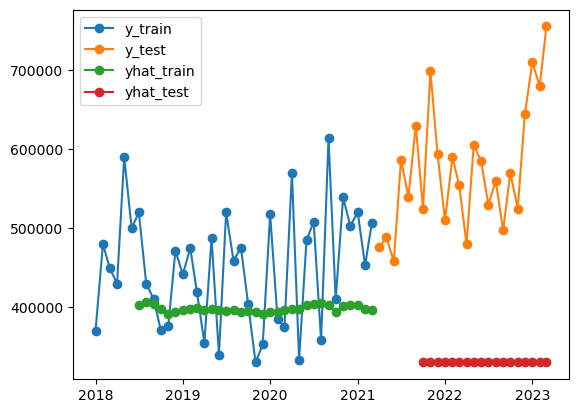

district_no 5 linear interpolation applied
Epoch 1/20


2023-04-05 21:17:05.740024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:06.814220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:07.355740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:07.846788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:08.627338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:09.225069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:09.815586: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 154ms/step - loss: 0.1202
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1056
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1038
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1026
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1029
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1020
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1048
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1013
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1025
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1033
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1003
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1014
Epoch 13/20
33/33 [===========================

2023-04-05 21:17:45.647932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:46.309413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:46.644871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:46.975389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 70505.89 RMSE
Test Score: 244527.72 RMSE


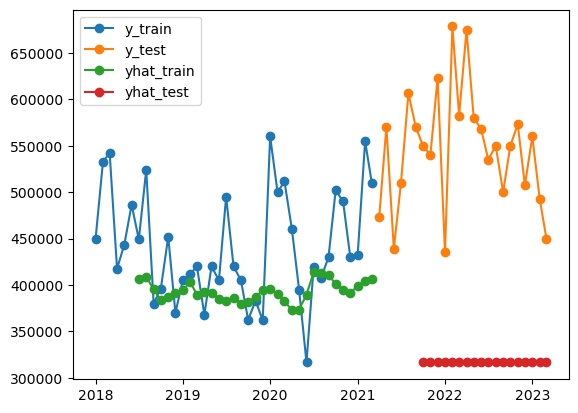

district_no 7 linear interpolation applied
Epoch 1/20


2023-04-05 21:17:55.483186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:56.656318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:57.282716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:57.791120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:58.500132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:59.143872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:17:59.731996: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 153ms/step - loss: 0.1143
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0943
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0961
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0938
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0952
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0948
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0947
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0935
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0942
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0965
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0938
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0947
Epoch 13/20
33/33 [===========================

2023-04-05 21:18:33.725204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:34.365768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:34.787096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:35.206259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 52113.84 RMSE
Test Score: 188147.55 RMSE


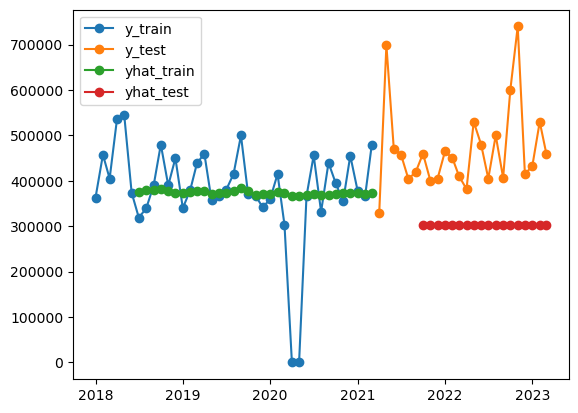

district_no 8 linear interpolation applied
Epoch 1/20


2023-04-05 21:18:45.079286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:46.189716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:46.817486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:47.369766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:48.134558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:48.743058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:18:49.376087: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 152ms/step - loss: 0.1106
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0908
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0916
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0916
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0916
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0916
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0922
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0914
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0919
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0913
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0910
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0906
Epoch 13/20
33/33 [===========================

2023-04-05 21:19:24.422386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:25.150074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:25.511594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:25.860799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 66693.04 RMSE
Test Score: 187852.82 RMSE


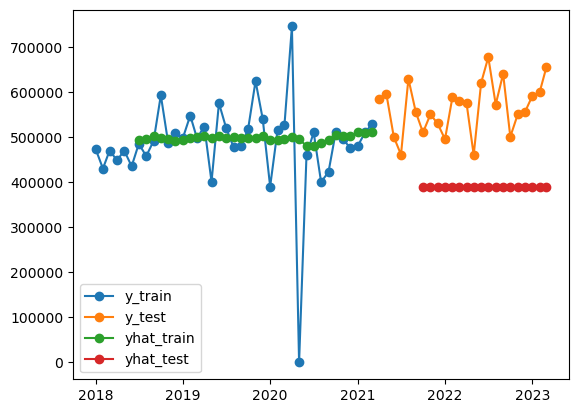

district_no 10 linear interpolation applied
Epoch 1/20


2023-04-05 21:19:35.059686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:36.167634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:36.715517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:37.239709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:37.960765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:38.545456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:19:39.131169: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 158ms/step - loss: 0.0660
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0624
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0629
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0610
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0612
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0618
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0610
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0606
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0606
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0610
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0614
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0625
Epoch 13/20
33/33 [===========================

2023-04-05 21:20:15.349207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:16.099206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:16.462776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:16.826884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 65701.50 RMSE
Test Score: 275993.26 RMSE


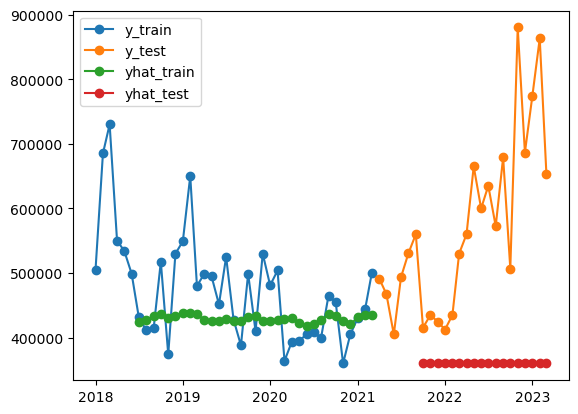

district_no 11 linear interpolation applied
Epoch 1/20


2023-04-05 21:20:25.283052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:26.392810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:27.035147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:27.610715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:28.374857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:29.002419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:29.649009: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 14s 206ms/step - loss: nan
Epoch 2/20
21/21 [==============================] - 1s 55ms/step - loss: nan
Epoch 3/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 4/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 5/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 6/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 7/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 8/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 9/20
21/21 [==============================] - 1s 44ms/step - loss: nan
Epoch 10/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 11/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 12/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 13/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoc

2023-04-05 21:20:53.043948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:53.703820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:54.141289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:20:54.510082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 4s 143ms/step
yhat train shape (21, 9)
yhat test shape (18, 9)
y train shape (21,)
y test shape (18,)
model for district 11 cannot be evaluated
district_no 12 linear interpolation applied
Epoch 1/20


2023-04-05 21:21:07.379746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:08.499100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:09.141148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:09.668849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:10.390760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:10.976478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:11.590929: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 149ms/step - loss: 0.1085
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0986
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0999
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1035
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0994
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0976
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0957
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0983
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0959
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0970
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0957
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0958
Epoch 13/20
33/33 [===========================

2023-04-05 21:21:45.341334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:46.056779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:46.615982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:47.040932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 97915.92 RMSE
Test Score: 346430.90 RMSE


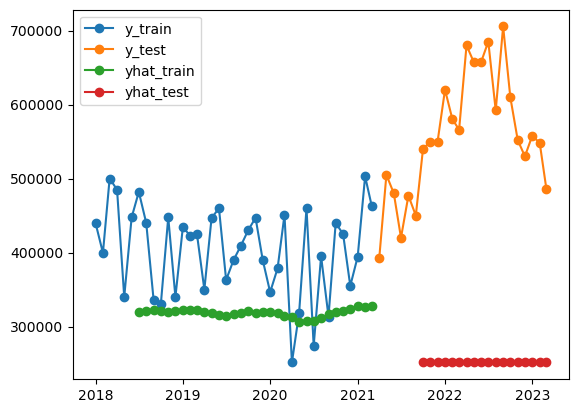

district_no 13 linear interpolation applied
Epoch 1/20


2023-04-05 21:21:56.057513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:57.180217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:57.833127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:58.355079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:59.148199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:21:59.802143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:00.444513: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 153ms/step - loss: 0.0978
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0718
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0721
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0739
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0716
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0705
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0705
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0694
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0691
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0688
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0686
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0682
Epoch 13/20
33/33 [===========================

2023-04-05 21:22:33.726539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:34.456806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:34.946561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:35.398784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 82419.42 RMSE
Test Score: 223126.43 RMSE


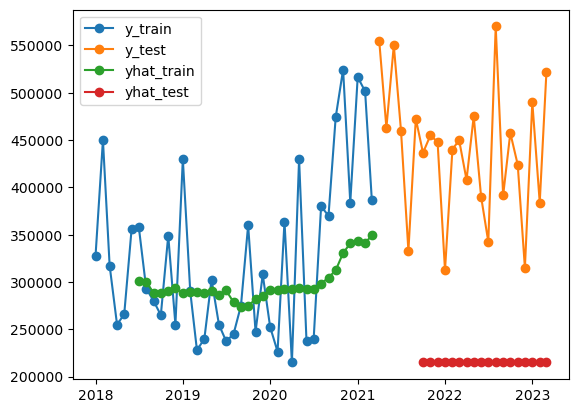

district_no 14 linear interpolation applied
Epoch 1/20


2023-04-05 21:22:44.718781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:45.769042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:46.381641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:47.093453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:47.882083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:48.514943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:22:49.136068: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 153ms/step - loss: 0.1058
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0855
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0856
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0861
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0852
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0865
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0862
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0882
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0853
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0848
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0848
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0845
Epoch 13/20
33/33 [===========================

2023-04-05 21:23:22.484285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:23.126587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:23.584463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:24.018484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 69691.16 RMSE
Test Score: 200349.75 RMSE


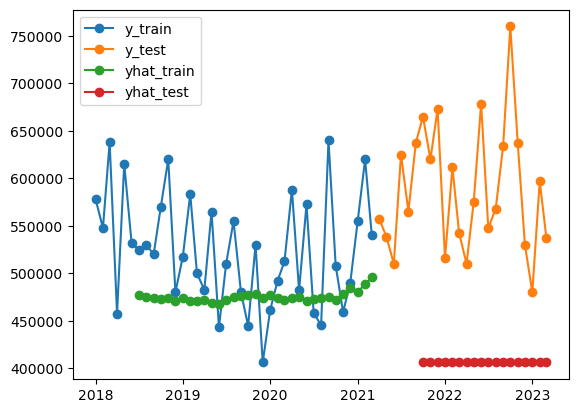

district_no 15 linear interpolation applied
Epoch 1/20


2023-04-05 21:23:33.066345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:34.138965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:34.786469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:35.342339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:36.100179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:36.763402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:23:37.374043: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 152ms/step - loss: 0.1190
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1053
Epoch 3/20
33/33 [==============================] - 2s 55ms/step - loss: 0.1087
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1081
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1054
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1064
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1056
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1041
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1041
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1075
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1084
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1097
Epoch 13/20
33/33 [===========================

2023-04-05 21:24:12.801207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:13.418086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:13.863148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:14.320991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 62769.34 RMSE
Test Score: 166301.78 RMSE


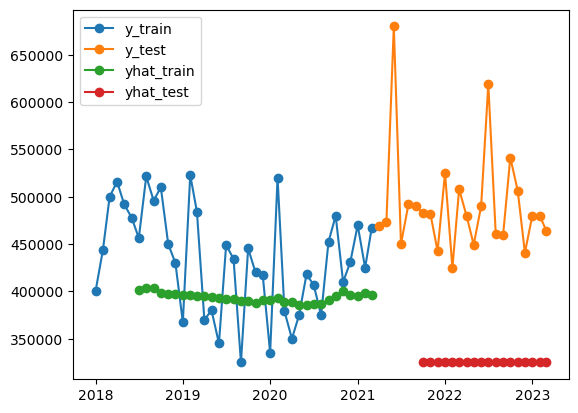

district_no 16 linear interpolation applied
Epoch 1/20


2023-04-05 21:24:23.032575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:24.140123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:24.878554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:25.398466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:26.243801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:26.875517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:24:27.510213: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 158ms/step - loss: 0.1033
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0902
Epoch 3/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0840
Epoch 4/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0838
Epoch 5/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0820
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0809
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0806
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0799
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0806
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0805
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0825
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0804
Epoch 13/20
33/33 [===========================

2023-04-05 21:25:02.717391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:03.396589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:03.900857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:04.370899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 21872.05 RMSE
Test Score: 122154.39 RMSE


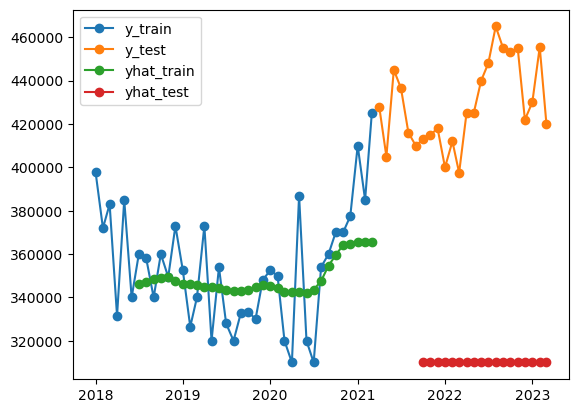

district_no 17 linear interpolation applied
Epoch 1/20


2023-04-05 21:25:14.838059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:15.982034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:16.759570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:17.347674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:18.130565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:18.828411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:19.456137: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 17s 166ms/step - loss: 0.0779
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0720
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0712
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0708
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0715
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0708
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0708
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0720
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0704
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0705
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0706
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0705
Epoch 13/20
33/33 [===========================

2023-04-05 21:25:54.554425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:55.200904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:55.666642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:25:56.202811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 188ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 67480.22 RMSE
Test Score: 186879.82 RMSE


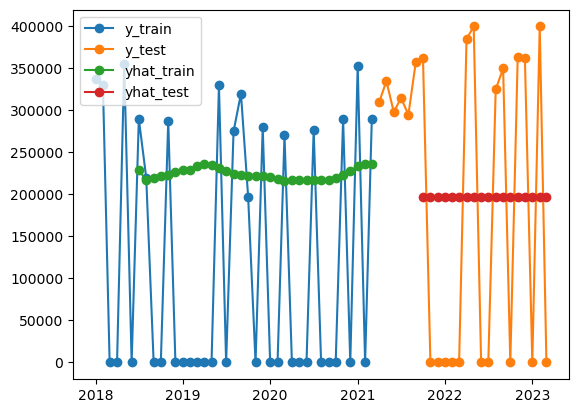

district_no 18 linear interpolation applied
Epoch 1/20


2023-04-05 21:26:08.854817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:10.036043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:10.676245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:11.240985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:12.037305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:12.712677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:13.385549: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 180ms/step - loss: 0.1194
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1136
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1124
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1076
Epoch 5/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1076
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1067
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1060
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1075
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1061
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1050
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1039
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1043
Epoch 13/20
33/33 [===========================

2023-04-05 21:26:48.500376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:49.195346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:49.700081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:26:50.140543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 20915.20 RMSE
Test Score: 134166.01 RMSE


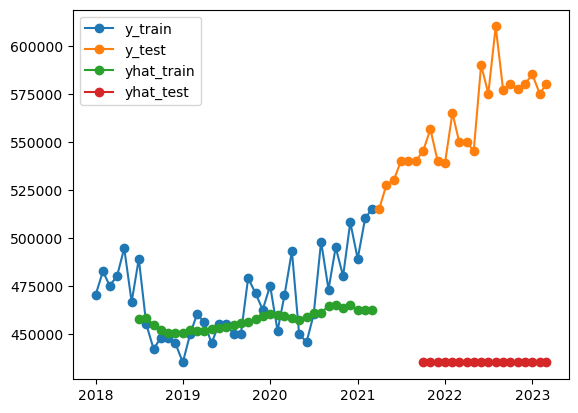

district_no 19 linear interpolation applied
Epoch 1/20


2023-04-05 21:27:00.421308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:01.683267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:02.372532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:02.975646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:03.865334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:04.520913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:05.162915: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 170ms/step - loss: 0.1100
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0935
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0930
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0912
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0915
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0909
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0903
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0896
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0905
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0913
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0915
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0905
Epoch 13/20
33/33 [===========================

2023-04-05 21:27:41.966853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:42.855174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:43.363239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:43.812885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 15244.56 RMSE
Test Score: 127446.46 RMSE


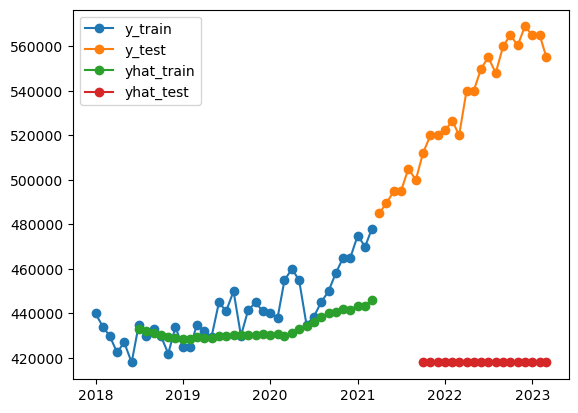

district_no 20 linear interpolation applied
Epoch 1/20


2023-04-05 21:27:53.119146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:54.389740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:55.182425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:55.791260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:56.792622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:57.570827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:27:58.290450: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 165ms/step - loss: 0.1168
Epoch 2/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1034
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1045
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1039
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1033
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1026
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1016
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1043
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1025
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1013
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0997
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1021
Epoch 13/20
33/33 [===========================

2023-04-05 21:28:32.885916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:33.664252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:34.039170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:34.485232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 46779.99 RMSE
Test Score: 180012.60 RMSE


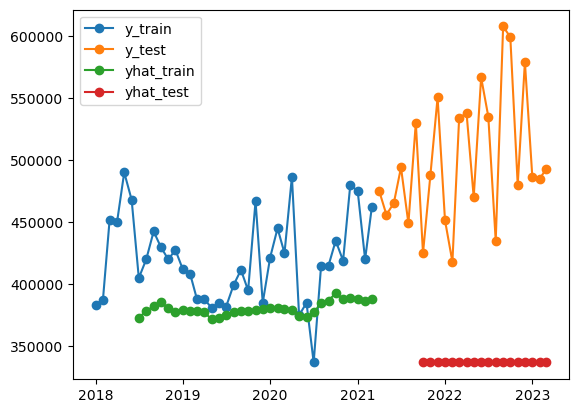

district_no 21 linear interpolation applied
Epoch 1/20


2023-04-05 21:28:45.391609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:46.667743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:47.343247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:48.022982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:48.801846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:49.465512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:28:50.123288: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 17s 172ms/step - loss: 0.1672
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1512
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1518
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1488
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1493
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1487
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1478
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1480
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1482
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1472
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1484
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1479
Epoch 13/20
33/33 [===========================

2023-04-05 21:29:24.899700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:25.545372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:26.062655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:26.591122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 19ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 307979.61 RMSE
Test Score: 532719.12 RMSE


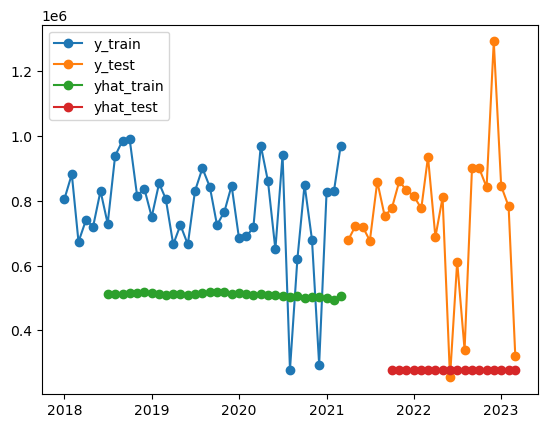

district_no 22 linear interpolation applied
Epoch 1/20


2023-04-05 21:29:36.206251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:37.374308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:38.078113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:38.761704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:39.723712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:40.492214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:29:41.538276: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 18s 202ms/step - loss: 0.1166
Epoch 2/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0992
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0969
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0979
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0997
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0974
Epoch 7/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0985
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0957
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0963
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0969
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0956
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0968
Epoch 13/20
33/33 [===========================

2023-04-05 21:30:18.251843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:19.031066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:19.501750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:19.920439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 22402.40 RMSE
Test Score: 124156.83 RMSE


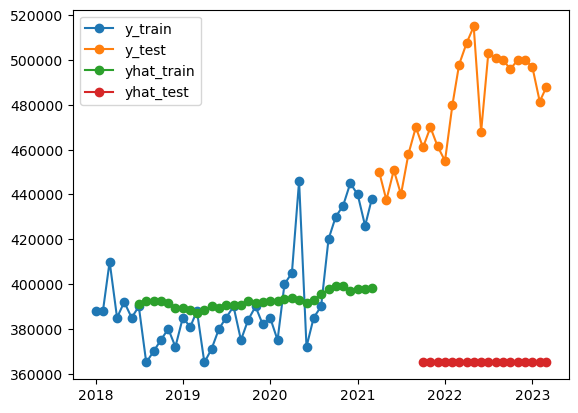

district_no 23 linear interpolation applied
Epoch 1/20


2023-04-05 21:30:30.830375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:32.054379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:32.728111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:33.270116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:34.085972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:34.737196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:30:35.451056: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 170ms/step - loss: 0.1228
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1073
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1107
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1083
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1089
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1048
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1079
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1063
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1039
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1050
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1046
Epoch 12/20
33/33 [==============================] - 2s 68ms/step - loss: 0.1057
Epoch 13/20
33/33 [===========================

2023-04-05 21:31:15.040527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:15.947673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:16.592651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:17.033468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 19ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 25654.12 RMSE
Test Score: 159013.19 RMSE


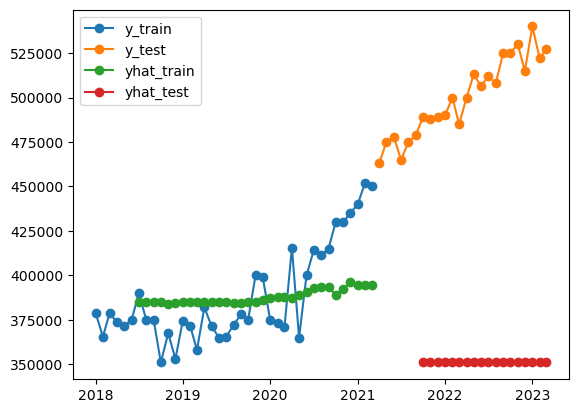

district_no 25 linear interpolation applied
Epoch 1/20


2023-04-05 21:31:27.532916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:28.845959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:29.550748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:30.105829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:30.945658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:31.629817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:31:32.370206: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 17s 184ms/step - loss: 0.1079
Epoch 2/20
33/33 [==============================] - 2s 52ms/step - loss: 0.1004
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0990
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0986
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0998
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0987
Epoch 7/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1003
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0984
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0980
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0980
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0982
Epoch 12/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0993
Epoch 13/20
33/33 [===========================

2023-04-05 21:32:08.433972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:09.221184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:09.751549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:10.246647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 25689.87 RMSE
Test Score: 164809.10 RMSE


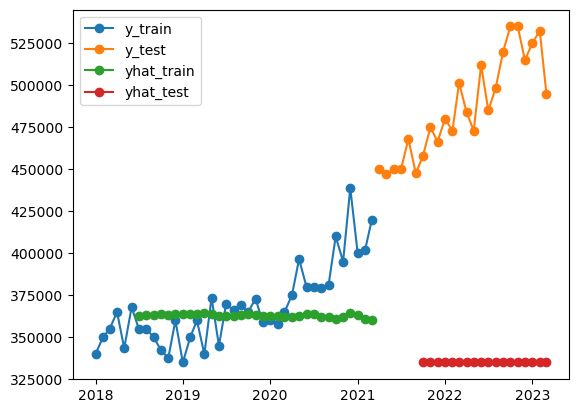

district_no 27 linear interpolation applied
Epoch 1/20


2023-04-05 21:32:21.618105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:22.946275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:23.820813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:24.535752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:25.475561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:26.238231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:32:26.984580: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 18s 174ms/step - loss: 0.1632
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1434
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1417
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1434
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1404
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1419
Epoch 7/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1401
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1402
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1421
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1400
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1404
Epoch 12/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1402
Epoch 13/20
33/33 [===========================

2023-04-05 21:33:02.870048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:03.698786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:04.240168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:04.790344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 24278.32 RMSE
Test Score: 146544.76 RMSE


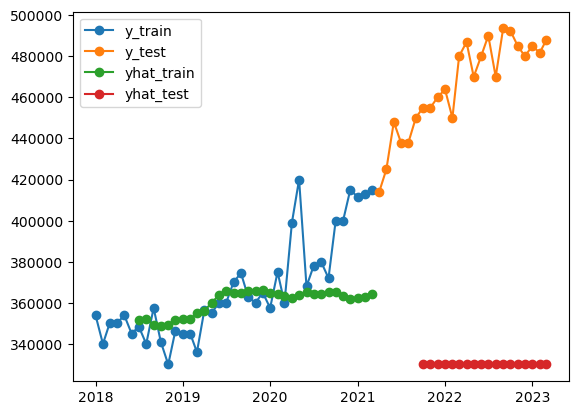

district_no 28 linear interpolation applied
Epoch 1/20


2023-04-05 21:33:14.797676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:16.112401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:16.916898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:17.544322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:18.353838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:19.095126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:19.774813: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 17s 173ms/step - loss: 0.1210
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1041
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1038
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1042
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1038
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1039
Epoch 7/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1033
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1018
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1018
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1013
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1012
Epoch 12/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1025
Epoch 13/20
33/33 [===========================

2023-04-05 21:33:55.111771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:55.747723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:56.286058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:33:56.683697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 9)
yhat test shape (18, 9)
y train shape (33,)
y test shape (18,)
Train Score: 18449.68 RMSE
Test Score: 131064.18 RMSE


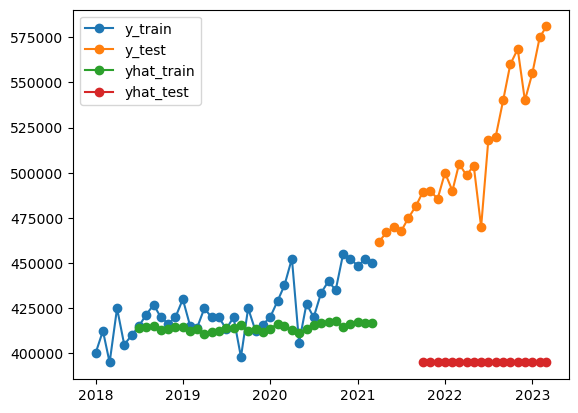

In [ ]:
def fit_lstm_L(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model

def evaluate_lstm_L(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict_L[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict_L[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict_L[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    try:
        train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
        print('Train Score: %.2f RMSE' % (train_score))
        test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
        print('Test Score: %.2f RMSE' % (test_score))
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score

# run the model for all districts with linear interpolation applied to the missing values
district_no_list = list(train_lstm_df_dict_L.keys())
test_score_dict_LI = {}

for district_no in district_no_list:
    print("district_no", district_no, "linear interpolation applied")
    model = fit_lstm_L(train_lstm_dataset_dict_L[district_no])
    test_score = evaluate_lstm_L(
        model=model,
        X_train=train_lstm_dataset_dict_L[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict_LI[district_no] = test_score 